## Multiloan_v2

### 0. Packages

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline
from pyhive import hive
import os
import time
import random
import math as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve, auc 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import Imputer
from sklearn.ensemble import  VotingClassifier
from sklearn2pmml import PMMLPipeline

from sklearn.cluster import FeatureAgglomeration
from sklearn import preprocessing

from lightgbm.sklearn import LGBMClassifier


import pyWoE
#import LR

plt.style.use('ggplot')
pd.set_option('display.width',500)
pd.set_option('display.max_columns',350)
pd.set_option('display.max_rows',250)

OutputPath='/home/jovyan/multi_loan/Multiloan/201809_multiloan_v2/'

### 1. Load Data

In [2]:
import findspark
findspark.init("/opt/spark")

import pandas as pd
import numpy as np
import os
from nxmodel import dstool
config = {
"spark.pyspark.driver.python":"/root/anaconda3/envs/python2.7/bin/python2.7",
"spark.pyspark.python":"/usr/local/python/bin/python2.7",
"spark.executor.memory": "16g",
"spark.dynamicAllocation.maxExecutors": "50",
"spark.dynamicAllocation.minExecutors": "10",
"spark.executorEnv.JAVA_HOME": "/usr/java/jdk1.8.0_74",
"spark.executor.cores": "1",
"spark.executorEnv.HADOOP_HOME":"/opt/cloudera/parcels/CDH/lib/hadoop",
"spark.executorEnv.HADOOP_COMMON_LIB_NATIVE_DIR":"/opt/cloudera/parcels/CDH/lib/hadoop/lib/native",
"spark.executorEnv.HADOOP_OPTS":"-Djava.library.path=/opt/cloudera/parcels/CDH/lib/hadoop/lib/native",
"spark.yarn.queue": "root.ds_prod_etl.default"
}

In [3]:
from pyhive import hive
import pandas as pd
rawdata_path = '/home/jovyan/multi_loan/Multiloan/201809_multiloan_v2/%s_%s_%s_loandata.csv' % ('2018-02-01', '2018-10-01', 'MultiloanV2')
if os.path.exists(rawdata_path):
    raw_data_loaned = pd.read_csv(rawdata_path, encoding='utf-8')
else:
    conn = hive.Connection(host='', port=10000, username='', password='', database='', auth='LDAP')
    raw_data_loaned = pd.read_sql("select t.* from table t", conn)
    raw_data_loaned.columns = raw_data_loaned.columns.str[2:]
    raw_data_loaned.to_csv(rawdata_path,index=False, sep=',', encoding='utf-8', header=True)
    print('已经保存在：' + rawdata_path)

In [4]:
raw_data_loaned['apply_date'] = raw_data_loaned.apply_time.str[:10]
raw_data_loaned['apply_month'] = raw_data_loaned.apply_time.str[:7]

In [5]:
from pyhive import hive
import pandas as pd
rawdata_path = '/home/jovyan/multi_loan/Multiloan/201809_multiloan_v2/%s_%s_%s_rejectdata.csv' % ('2018-02-01', '2018-10-01', 'MultiloanV2')
if os.path.exists(rawdata_path):
    raw_data_noloan = pd.read_csv(rawdata_path, encoding='utf-8')
else:
    conn = hive.Connection(host='', port=10000, username='', password='', database='', auth='LDAP')
    raw_data_noloan = pd.read_sql("select t.* from table t", conn)
    raw_data_noloan.columns = raw_data_noloan.columns.str[2:]
    raw_data_noloan.to_csv(rawdata_path,index=False, sep=',', encoding='utf-8', header=True)
    print('已经保存在：' + rawdata_path)

In [6]:
raw_data_noloan['apply_date'] = raw_data_noloan.apply_time.str[:10]
raw_data_noloan['apply_month'] = raw_data_noloan.apply_time.str[:7]

In [7]:
# 时间窗口划分, 4，5，6为INS，7，8为OOT，9月未完全进入表现期，3月为OOT1
date1 = '2018-03-01'
date2 = '2018-04-01'
date3 = '2018-07-01'
date4 = '2018-09-01'

target_label = 'label_3'

def row_grouping(row):
    if (row['apply_date'] >= date2 and row['apply_date'] < date3)  and row['RandNum'] <= 0.7:
        return 'INS'  # 70%训练集
    elif (row['apply_date'] >= date2 and row['apply_date'] < date3) and row['RandNum'] > 0.3:
        return 'OOS'  # 30%验证集
    elif row['apply_date'] >= date1 and row['apply_date'] < date2:
        return 'OOT1'  # OOT1
    elif row['apply_date'] >= date3 and row['apply_date'] < date4:
        return 'OOT2'  # OOT2
    return 'NA'

In [8]:
raw_data_full=pd.concat([raw_data_loaned,raw_data_noloan]) # 全部订单，包括抽样20%的拒绝订单和覆盖同盾贷后的全部拒绝订单
# 全部覆盖贷后同盾的通过订单上进行模型训练
# is_multiloan_3 有四个值，null表示未进入21天的表现期，-1表示未覆盖到贷后同盾，0为贷后21天7次以下，1表示贷后21天查询7次以上
label ='is_multiloan_3'
raw_data_all = raw_data_full.loc[raw_data_full[label].isin([0,1]),:] 
raw_data_loaned.loc[:, 'RandNum'] = [random.random() for i in range(len(raw_data_loaned))]
raw_data_loaned.loc[:, 'Group'] = raw_data_loaned.apply(row_grouping, axis=1)
# 选择明确定义的正负样本，0样本种剔除灰样本，保证完全好用户
raw_data=raw_data_loaned.loc[raw_data_loaned[target_label].isin([0,1]),:] 
raw_data_ins = raw_data[raw_data['Group'] == 'INS']


### 2. Exploratory Data Analysis

#### 2.1 Target Distribution

In [9]:
def sample_distribution(df,label,TargetVar):
    
    distri_df = pd.DataFrame()
    GROUP = []
    TOTAl = []
    group = sorted(list(set(df[label])))
    for i in group:
        df_current = df.loc[df[label]==i,:]
        total_current = len(df_current)
        
        GROUP.append(i)
        TOTAl.append(total_current)
    
    distri_df.loc[:,'group'] = GROUP
    distri_df.loc[:,'total'] = TOTAl
    
    for target_label in TargetVar:
        TARGET = []
        TARGET_RATIO = []
        for i in group:
            df_current = df.loc[df[label]==i,:]
            if len(df_current)==0:
                break
            total_current = len(df_current)
            target_current = int(df_current[target_label].sum())
            target_ratio_current = format(np.round(target_current/total_current,4),'.2%')
        
            TARGET.append(target_current)
            TARGET_RATIO.append(target_ratio_current)
    
        distri_df.loc[:,target_label] = TARGET
        distri_df.loc[:,target_label+'_ratio'] = TARGET_RATIO
    
    return distri_df


In [10]:
sample_distribution(raw_data,'Group',['s1d30','s3d15','s1d4_30','s3d15','is_multiloan_3','label_3'])

,group,total,s1d30,s1d30_ratio,s3d15,s3d15_ratio,s1d4_30,s1d4_30_ratio,is_multiloan_3,is_multiloan_3_ratio,label_3,label_3_ratio
0,INS,170732,377,0.22%,1606,0.94%,126,0.07%,19083,11.18%,19083,11.18%
1,NA,47434,43,0.09%,230,0.48%,21,0.04%,3876,8.17%,3876,8.17%
2,OOS,73829,176,0.24%,728,0.99%,50,0.07%,8368,11.33%,8368,11.33%
3,OOT1,70378,137,0.19%,588,0.84%,41,0.06%,7912,11.24%,7912,11.24%
4,OOT2,67648,114,0.17%,273,0.40%,101,0.15%,6835,10.10%,6835,10.10%


In [11]:
sample_distribution(raw_data,'apply_month',['s1d30','s3d15','is_multiloan_3','s1d4_30','s3d30'])

,group,total,s1d30,s1d30_ratio,s3d15,s3d15_ratio,is_multiloan_3,is_multiloan_3_ratio,s1d4_30,s1d4_30_ratio,s3d30,s3d30_ratio
0,2018-02,46654,43,0.09%,230,0.49%,3874,8.30%,21,0.05%,220,0.47%
1,2018-03,70378,137,0.19%,588,0.84%,7912,11.24%,41,0.06%,571,0.81%
2,2018-04,80165,159,0.20%,658,0.82%,8022,10.01%,53,0.07%,629,0.78%
3,2018-05,84409,197,0.23%,792,0.94%,9038,10.71%,50,0.06%,767,0.91%
4,2018-06,79987,197,0.25%,884,1.11%,10391,12.99%,73,0.09%,621,0.78%
5,2018-07,47625,102,0.21%,230,0.48%,5128,10.77%,97,0.20%,157,0.33%
6,2018-08,20023,12,0.06%,43,0.21%,1707,8.53%,4,0.02%,12,0.06%
7,2018-09,780,0,0.00%,0,0.00%,2,0.26%,0,0.00%,0,0.00%


#### 2.2 Data Structure 

In [12]:
raw_data_ins.dtypes.value_counts()

float64    282
int64       69
object       5
dtype: int64

##### 2.2.1 Category Values
Categorical variables in raw_data_ins are not necessary

In [13]:
raw_data_ins.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

apply_time     167707
dt                 91
apply_date         91
apply_month         3
Group               1
dtype: int64

##### 2.2.2  Numerical Values

In [14]:
def EDD_Calculate(InputDf,GroupVar,GroupValue,Cols):
    Output=pd.DataFrame()
    for Group_i in set(GroupValue):
        OutputPre=pd.DataFrame()
        OutputPre=pd.DataFrame(InputDf[InputDf[GroupVar]==Group_i][Cols].describe().T,)
        OutputPre.loc[:,'TotalCount']=InputDf[InputDf[GroupVar]==Group_i][Cols].fillna(0).count()
        OutputPre.loc[:,GroupVar]=Group_i
        Output=pd.concat([Output,OutputPre],axis=0)
    return Output

In [15]:
all_cols = list(raw_data_ins.columns)
except_cols = ['user_id', 'order_id', 'apply_time', 'dt', 'apply_date','apply_month', 'Group','id','RandNum']
edd_features = [x for x in set(all_cols) if x not in set(except_cols)]
print('全部特征数为: %d' % len(all_cols))
print('数值型特征数为: %d' % len(edd_features))

全部特征数为: 356
数值型特征数为: 347


In [16]:
GroupVar = 'Group'
GroupValue = ['INS','OOS','OOT1','OOT2']
Cols = edd_features
EDD_df = EDD_Calculate(raw_data,GroupVar,GroupValue,Cols)
EDD_df.to_csv(OutputPath+'/MultiLoan_V2_Feature_EDD_label_21d_1016.csv')

#### 2.3 Missing Values

In [17]:
def missing_values_table(data):
    """
    该函数用来实现特征缺失情况的统计
    :param data: 输入的dataframe
    :return: 缺失情况统计
    """
    miss_val = data.isnull().sum() # Total Missing Values
    miss_val_percent = 100 * data.isnull().sum()/len(data) # Percentage of missing values
    miss_val_df = pd.concat([miss_val, miss_val_percent],axis = 1) 
    miss_val_table = miss_val_df.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    miss_val_table = miss_val_table[miss_val_table.iloc[:,1]!=0].sort_values('% of Total Values',ascending=False).round(1)
    
    # Print some summary information
    print('Your selected dataframe has ' +str(data.shape[1]) + 'columns.\n'
         'There are' + str(miss_val_table.shape[0]) +'columns that have missing values')
    
    return miss_val_table

In [18]:
missing_values = missing_values_table(raw_data_ins)
#missing_values.head(50)

Your selected dataframe has 356columns.
There are89columns that have missing values


In [19]:
missing_values.head(100)

,Missing Values,% of Total Values
this_0to1m_virtual_num,96057,56.3
this_0to2m_gamble_num,96057,56.3
this_0to1m_cash_num,96057,56.3
this_0to1m_back_num,96057,56.3
this_0to1m_robbing_num,96057,56.3
this_0to1m_pyramid_num,96057,56.3
this_0to1m_gamble_num,96057,56.3
this_0to1m_allocation_num,96057,56.3
this_0to1m_invest_num,96057,56.3
this_0to1m_forward_num,96057,56.3


#### 2.4 Anomalies Check

In [20]:
raw_data_ins.describe()

,user_id,order_id,id,app_platform_num_1m,app_platform_num_7d,app_platform_num_3m,app_platform_num_6m,app_platform_num_12m,app_platform_num_18m,app_platform_num_24m,app_platform_num_1m_avg,app_platform_num_3m_avg,app_platform_num_6m_avg,app_platform_num_12m_avg,app_platform_num_18m_avg,app_platform_num_7d1m,app_platform_num_7d3m,app_platform_num_1m3m,app_platform_num_7d6m,app_platform_num_1m6m,app_platform_num_3m6m,app_platform_num_7d12m,app_platform_num_1m12m,app_platform_num_3m12m,app_platform_num_6m12m,app_platform_num_7d18m,app_platform_num_1m18m,app_platform_num_3m18m,app_platform_num_6m18m,app_platform_num_12m18m,app_platform_num_7d24m,app_platform_num_1m24m,app_platform_num_3m24m,app_platform_num_6m24m,app_platform_num_12m24m,app_platform_num_18m24m,app_consbank_num_1m,app_consbank_num_7d,app_consbank_num_3m,app_consbank_num_6m,app_consbank_num_12m,app_consbank_num_18m,app_consbank_num_24m,app_consbank_num_1m_avg,app_consbank_num_3m_avg,app_consbank_num_6m_avg,app_consbank_num_12m_avg,app_consbank_num_18m_avg,app_consbank_num_7d1m,app_consbank_num_7d3m,app_consbank_num_1m3m,app_consbank_num_7d6m,app_consbank_num_1m6m,app_consbank_num_3m6m,app_consbank_num_7d12m,app_consbank_num_1m12m,app_consbank_num_3m12m,app_consbank_num_6m12m,app_consbank_num_7d18m,app_consbank_num_1m18m,app_consbank_num_3m18m,app_consbank_num_6m18m,app_consbank_num_12m18m,app_consbank_num_7d24m,app_consbank_num_1m24m,app_consbank_num_3m24m,app_consbank_num_6m24m,app_consbank_num_12m24m,app_consbank_num_18m24m,app_consfina_num_1m,app_consfina_num_7d,app_consfina_num_3m,app_consfina_num_6m,app_consfina_num_12m,app_consfina_num_18m,app_consfina_num_24m,app_consfina_num_1m_avg,app_consfina_num_3m_avg,app_consfina_num_6m_avg,app_consfina_num_12m_avg,app_consfina_num_18m_avg,app_consfina_num_7d1m,app_consfina_num_7d3m,app_consfina_num_1m3m,app_consfina_num_7d6m,app_consfina_num_1m6m,app_consfina_num_3m6m,app_consfina_num_7d12m,app_consfina_num_1m12m,app_consfina_num_3m12m,app_consfina_num_6m12m,app_consfina_num_7d18m,app_consfina_num_1m18m,app_consfina_num_3m18m,app_consfina_num_6m18m,app_consfina_num_12m18m,app_consfina_num_7d24m,app_consfina_num_1m24m,app_consfina_num_3m24m,app_consfina_num_6m24m,app_consfina_num_12m24m,app_consfina_num_18m24m,app_consinst_num_1m,app_consinst_num_7d,app_consinst_num_3m,app_consinst_num_6m,app_consinst_num_12m,app_consinst_num_18m,app_consinst_num_24m,app_consinst_num_1m_avg,app_consinst_num_3m_avg,app_consinst_num_6m_avg,app_consinst_num_12m_avg,app_consinst_num_18m_avg,app_consinst_num_7d1m,app_consinst_num_7d3m,app_consinst_num_1m3m,app_consinst_num_7d6m,app_consinst_num_1m6m,app_consinst_num_3m6m,app_consinst_num_7d12m,app_consinst_num_1m12m,app_consinst_num_3m12m,app_consinst_num_6m12m,app_consinst_num_7d18m,app_consinst_num_1m18m,app_consinst_num_3m18m,app_consinst_num_6m18m,app_consinst_num_12m18m,app_consinst_num_7d24m,app_consinst_num_1m24m,app_consinst_num_3m24m,app_consinst_num_6m24m,app_consinst_num_12m24m,app_consinst_num_18m24m,app_pettloan_num_1m,app_pettloan_num_7d,app_pettloan_num_3m,app_pettloan_num_6m,app_pettloan_num_12m,app_pettloan_num_18m,app_pettloan_num_24m,app_pettloan_num_1m_avg,app_pettloan_num_3m_avg,app_pettloan_num_6m_avg,app_pettloan_num_12m_avg,app_pettloan_num_18m_avg,app_pettloan_num_7d1m,app_pettloan_num_7d3m,app_pettloan_num_1m3m,app_pettloan_num_7d6m,app_pettloan_num_1m6m,app_pettloan_num_3m6m,app_pettloan_num_7d12m,app_pettloan_num_1m12m,app_pettloan_num_3m12m,app_pettloan_num_6m12m,app_pettloan_num_7d18m,app_pettloan_num_1m18m,app_pettloan_num_3m18m,app_pettloan_num_6m18m,app_pettloan_num_12m18m,app_pettloan_num_7d24m,app_pettloan_num_1m24m,app_pettloan_num_3m24m,app_pettloan_num_6m24m,app_pettloan_num_12m24m,app_pettloan_num_18m24m,app_p2p_num_1m,app_p2p_num_7d,app_p2p_num_3m,app_p2p_num_6m,app_p2p_num_12m,app_p2p_num_18m,app_p2p_num_24m,...,app_p2p_num_3m_avg,app_p2p_num_6m_avg,app_p2p_num_12m_avg,app_p2p_num_18m_avg,app_p2p_num_7d1m,app_p2p_num_7d3m,app_p2p_num_1m3m,app_p2p_num_7

In [21]:
# 删除常数特征后的数据
raw_data_ins_1 = raw_data_ins
raw_data_ins_1 = raw_data_ins_1.loc[:,(raw_data_ins_1 != raw_data_ins_1.iloc[0]).any()]

In [22]:
const_cols = [x for x in set(raw_data_ins.columns) if x not in set(raw_data_ins_1.columns)]

In [23]:
const_cols

['apply_after_cnt',
 'is_in_21d',
 'riskinfo_riskcode_404',
 'service_supervision_cnt',
 'riskinfo_riskcode_405',
 'Group',
 'riskinfo_riskcode_406',
 'guarantee_cnt',
 'riskinfo_riskcode_402',
 'other_cnt',
 'is_eff_s1d30',
 'is_loan',
 'riskinfo_riskcode_401',
 'is_in_30d',
 'riskinfo_riskcode_403',
 'riskinfo_riskcode_407']

#### 2.5 Correlation 

In [24]:
# Find Correlations with target and sort
except_cols = ['user_id', 'order_id','id','apply_time', 'dt','is_multiloan_1','is_multiloan_2','is_multiloan_3','is_multiloan_4'
               ,'label_1','label_2','label_4','s1d30','s3d15','s3d30','s1d4_30','is_loan','is_in_30d','is_in_21d'
               , 'is_eff_s1d30','is_eff_s3d15','apply_date','apply_month','RandNum','Group','riskinfo_riskcode_402'
              , 'riskinfo_riskcode_404','riskinfo_riskcode_401','riskinfo_riskcode_406','riskinfo_riskcode_407'
              , 'riskinfo_riskcode_405','riskinfo_riskcode_403','apply_after_cnt','service_supervision_cnt'
              , 'generationamount','guarantee_cnt','other_cnt']
all_cols = raw_data.columns
corr_cols = [x for x in set(all_cols) if x not in set(except_cols)]
raw_data_corr = raw_data_ins[corr_cols]
correlations = raw_data_corr.corr()[target_label].sort_values()

# Display correlations
print('Most postive correlations are:\n ',correlations.tail(15))
print('Most negative correlations are:\n', correlations.head(15))

Most postive correlations are:
  app_consinst_num_12m    0.191093
app_p2p_num_18m         0.199475
app_consinst_num_6m     0.201277
app_consinst_num_3m     0.206945
app_platform_num_24m    0.209674
app_platform_num_18m    0.216061
app_p2p_num_12m         0.217028
app_p2p_num_1m          0.222799
app_platform_num_12m    0.231136
app_p2p_num_6m          0.239705
app_p2p_num_3m          0.247051
app_platform_num_6m     0.252773
app_platform_num_1m     0.253011
app_platform_num_3m     0.266629
label_3                 1.000000
Name: label_3, dtype: float64
Most negative correlations are:
 debit_installment_autoid_cnt_t_ratio        -0.022216
bank_num                                    -0.015577
debit_installment_autoid_cnt_t_ratio_l9     -0.010212
debit_installment_amountmoney_out_t_ratio   -0.008236
debit_installment_amountmoney_out_t         -0.006954
debit_installment_autoid_cnt_t_ratio_l6     -0.005877
app_consfina_num_18m_avg                    -0.004230
is_creditcard_instalment       

#### 2.6 IV Check

In [25]:
# IV 值计算
target_label = 'label_3'
print('label为: %s' % target_label)
print('输出各变量的IV...')

VAR = []
IV = []
    
woe = pyWoE.WoE(qnt_num=10, min_block_size=10, v_type='c', t_type='b')

continues_cols = [x for x in set(all_cols) if x not in set(except_cols)]

for var_name in continues_cols:
    woe.fit(pd.Series(raw_data_ins[var_name]), pd.Series(raw_data_ins[target_label]))
    VAR.append(var_name)
    IV.append(woe.iv)

iv_df = pd.DataFrame({"feature": VAR})
iv_df.loc[:, 'IV'] = IV
iv_df.loc[:, 'label'] = target_label
iv_df = iv_df.sort_values(by=['IV'], ascending=False)
iv_df.loc[:, 'idx'] = range(len(iv_df))
iv_df.to_csv(OutputPath+'MultiLoan_V2_Feature_IV.csv')

label为: label_3
输出各变量的IV...


In [26]:
print(iv_df.iloc[0:100,:])

                       feature        IV    label  idx
270        app_platform_num_3m  0.653534  label_3    0
267        app_platform_num_6m  0.598239  label_3    1
231        app_platform_num_1m  0.564031  label_3    2
281       app_platform_num_12m  0.529708  label_3    3
197             app_p2p_num_6m  0.498739  label_3    4
232       app_platform_num_18m  0.477913  label_3    5
234            app_p2p_num_12m  0.471101  label_3    6
208       app_platform_num_24m  0.453228  label_3    7
274             app_p2p_num_3m  0.421263  label_3    8
262            app_p2p_num_18m  0.410153  label_3    9
196            app_p2p_num_24m  0.386740  label_3   10
104             app_p2p_num_1m  0.356245  label_3   11
93        app_consinst_num_12m  0.322592  label_3   12
4             app_p2p_num_1m3m  0.316646  label_3   13
278       app_consinst_num_18m  0.304417  label_3   14
71            app_p2p_num_1m6m  0.300543  label_3   15
283       app_consinst_num_24m  0.300246  label_3   16
46        

### 3. Feature Engineering 

#### 3.1 Handle Missing Values

In [27]:
# ① Android中applist变量的缺失用999999填充，Ios保留缺失不进行填充
# ② 信用卡消费分期银行数bank_num缺失是因为没有分期消费明细，可填充为0
# ③ 中金协数据是在201802之后才接入的，选样本集为201802之后的
# ④ 借记卡特征cnt缺失是未爬取到借记卡信息，ratio多出的缺失是无借记卡消费信息
raw_data_total = raw_data
raw_data['bank_num'].fillna(0, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### 3.2 Handle Anomaly Features 

In [28]:
# Delete some features with an unique value
except_cols.append('label_3')
final_cols = [x for x in set(raw_data.columns) if x not in set(except_cols)]

In [29]:
len(final_cols)

318

#### 3.3 Feature Construction

##### 3.3.1 中金协变量消除量纲 
问题：线下按月消除量纲，线上实时变量无法达到,暂时不采用此处理

In [28]:
fin_cols = ['loancount','loanamt','outstandcount','loanbal','overduecount','overdueamt','overduemorecount'
                  ,'overduemoreamt','generationcount','total_cnt','apply_before_cnt','apply_month']

raw_data_fin = raw_data[fin_cols]

In [44]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def MinMaxScale(Data, Features, Group):
    group_list = []
    scaler = MinMaxScaler()
    ScaleData = pd.DataFrame()
    for i in sorted(list(set(Data[Group]))):
        TempData = Data.loc[Data[Group]==i,:]
        transformdata = TempData[Features]
        transformdata = transformdata.drop([Group],axis=1)
        transformdata.fillna(value=0,inplace=True)
        ScaledTempData = scaler.fit_transform(transformdata)
        ScaledTempData = pd.DataFrame(ScaledTempData)
        group_list.append(i)
        
    ScaleData = pd.concat([ScaleData,ScaledTempData,],axis=1)
    return ScaleData
            

In [45]:
tt = MinMaxScale(raw_data, fin_cols, 'apply_month')

##### 3.3.2  针对筛选后的特征进行特征构造
采用gplearn包

In [66]:
from gplearn.genetic import SymbolicRegressor
from gplearn.genetic import SymbolicTransformer
 
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log','abs', 'max', 'min']             
gp = SymbolicTransformer(generations=10, population_size=500,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)           


In [65]:
selected = ['loancount','app_platform_num_1m','app_platform_num_6m','app_platform_num_3m_ratio','loanamt','loanbal','app_p2p_num_6m_ratio','app_platform_num_3m24m','app_platform_num_12m24m','this_gamble_ratio','app_platform_num_12m18m','app_platform_num_18m24m','app_platform_num_7d24m','app_platform_num_3m','app_platform_num_1m_ratio','app_platform_num_6m12m','app_platform_num_12m','bank_num','app_platform_num_1m24m','app_platform_num_3m12m','app_platform_num_7d6m','app_platform_num_7d','app_platform_num_6m24m','app_platform_num_6m18m','app_platform_num_24m','app_platform_num_1m18m','this_0to1m_gamble_num','app_platform_num_3m18m','app_p2p_num_1m','app_platform_num_1m12m','app_p2p_num_18m24m','app_platform_num_3m6m','app_platform_num_7d1m','app_p2p_num_7d6m','app_p2p_num_6m18m','app_p2p_num_12m24m','app_platform_num_7d3m','app_p2p_num_6m12m','app_platform_num_1m6m','app_p2p_num_6m','app_p2p_num_12m','app_p2p_num_6m24m','app_p2p_num_3m12m','app_p2p_num_7d24m','app_consinst_num_3m','app_consinst_num_3m6m','app_p2p_num_3m_ratio','app_p2p_num_12m18m','app_consinst_num_6m24m','app_consinst_num_12m18m','app_p2p_num_3m18m','app_consinst_num_1m12m','app_consinst_num_6m12m','app_p2p_num_1m_ratio','app_consinst_num_1m_ratio','app_p2p_num_7d18m','app_consinst_num_12m24m','app_consinst_num_1m','app_consinst_num_7d24m','app_platform_num_3m_avg','app_p2p_num_7d12m','app_p2p_num_3m24m','app_consinst_num_1m24m','app_platform_num_7d12m','app_p2p_num_18m','app_consfina_num_3m12m','app_platform_num_6m_avg','app_p2p_num_1m24m','app_pettloan_num_6m24m','app_consbank_num_1m_ratio','app_p2p_num_7d3m','app_consinst_num_1m6m','app_platform_num_7d18m','app_pettloan_num_12m24m','app_p2p_num_1m3m','app_p2p_num_1m6m','app_platform_num_1m_avg','app_consinst_num_3m24m','app_pettloan_num_12m18m','app_pettloan_num_3m24m','app_pettloan_num_6m18m','app_pettloan_num_6m12m','app_p2p_num_1m12m','app_pettloan_num_18m24m','app_consinst_num_18m24m','app_p2p_num_3m6m','app_consbank_num_6m12m','app_consinst_num_24m','app_consinst_num_3m12m','app_consfina_num_12m24m','app_consbank_num_12m18m','app_pettloan_num_1m24m','app_consinst_num_6m','app_consinst_num_7d3m','app_consinst_num_6m18m','app_p2p_num_7d1m','app_p2p_num_6m_avg','app_consinst_num_18m','app_p2p_num_24m','app_pettloan_num_3m6m','app_consbank_num_3m24m','app_p2p_num_1m_avg','app_pettloan_num_24m','app_platform_num_18m','app_p2p_num_3m','app_consinst_num_7d18m','app_consinst_num_12m','app_consfina_num_12m','app_consbank_num_3m12m','app_pettloan_num_1m3m','app_consinst_num_1m18m','app_pettloan_num_6m','app_consbank_num_1m6m','app_p2p_num_7d','app_consinst_num_7d6m','app_consinst_num_3m_avg','app_p2p_num_1m18m','app_consfina_num_18m','app_platform_num_1m3m','app_pettloan_num_12m','app_consinst_num_1m3m','app_consbank_num_12m24m','app_consbank_num_1m12m','app_consbank_num_12m','app_pettloan_num_1m6m','app_pettloan_num_3m18m','app_consbank_num_3m','app_pettloan_num_1m12m','app_consbank_num_6m','app_pettloan_num_3m12m','app_consinst_num_1m_avg','app_consbank_num_3m6m','app_consinst_num_3m18m','app_consbank_num_18m','app_consbank_num_6m24m','app_consbank_num_1m24m','app_pettloan_num_18m','app_pettloan_num_3m','app_consbank_num_24m','app_consfina_num_18m24m','app_consfina_num_24m','app_consinst_num_7d1m','app_pettloan_num_1m_avg','app_pettloan_num_1m','app_consinst_num_7d12m','app_consinst_num_7d','app_p2p_num_3m_avg','app_consbank_num_6m18m','app_consbank_num_3m18m','app_consbank_num_18m24m','app_consfina_num_12m18m','app_pettloan_num_1m18m','app_consbank_num_1m','app_consbank_num_1m18m','app_consbank_num_1m3m']

In [ ]:
# gp.fit(X=raw_data_ins_st[selected], y=raw_data_ins_st['is_multiloan_1'])                           
print(gp)                                                     
gp_features = gp.transform(raw_data_st[selected])                       
gp_feature_df = pd.DataFrame(gp_features, columns=['gp_feat' + str(i) for i in range(len(gp_features[0]))])
print(gp_feature_df.head())


In [ ]:
# 特征有效性检验
for feat in list(gp_feature_df.columns):                             
    ks = Compute_KS(proba=gp_feature_df[feat], target=df[target])
    print(ks)
    
raw_data_corr.corr()[target_label].sort_values()

#### 3.4 Feature Selection 

##### 3.4.1 采用Boruta 包
Boruta主要是基于特征与目标变量的相关性进行特征过滤

In [30]:
from __future__ import print_function
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier # 随机森林算法
from boruta import BorutaPy #Boruta模块
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
# 时间计算
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [31]:
# 填充缺失值的数据
raw_data_st = raw_data.copy()
raw_data_st.fillna(-999999,inplace=True)
raw_data_ins_st = raw_data_st[raw_data_st['Group'] == 'INS']
raw_data_oos_st = raw_data_st[raw_data_st['Group'] == 'OOS']
X_ins_st = pd.DataFrame(raw_data_ins_st[final_cols],dtype=np.float)
X_oos_st = pd.DataFrame(raw_data_oos_st[final_cols],dtype=np.float)
y_ins_st = raw_data_ins_st['label_3'].ravel()

In [32]:
# 使用随机森林模型
X = X_ins_st.values
y = y_ins_st
rfc = RandomForestClassifier(n_estimators=30, n_jobs=50, class_weight='balanced', max_depth=3)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2)
start_time = timer(None)
boruta_selector.fit(X, y)
timer(start_time)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	318
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	318
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	318
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	318
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	318
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	318
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	318
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	146
Tentative: 	83
Rejected: 	89


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	146
Tentative: 	83
Rejected: 	89


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	146
Tentative: 	83
Rejected: 	89


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	146
Tentative: 	83
Rejected: 	89


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	149
Tentative: 	80
Rejected: 	89


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	149
Tentative: 	80
Rejected: 	89


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	149
Tentative: 	74
Rejected: 	95


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	149
Tentative: 	74
Rejected: 	95


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	150
Tentative: 	73
Rejected: 	95


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	150
Tentative: 	66
Rejected: 	102


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	150
Tentative: 	66
Rejected: 	102


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	152
Tentative: 	64
Rejected: 	102


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	152
Tentative: 	64
Rejected: 	102


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	152
Tentative: 	64
Rejected: 	102


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	152
Tentative: 	64
Rejected: 	102


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	152
Tentative: 	64
Rejected: 	102


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	152
Tentative: 	63
Rejected: 	103


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	152
Tentative: 	63
Rejected: 	103


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	152
Tentative: 	63
Rejected: 	103


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	152
Tentative: 	58
Rejected: 	108


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	152
Tentative: 	58
Rejected: 	108


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	153
Tentative: 	57
Rejected: 	108


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	153
Tentative: 	57
Rejected: 	108


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	153
Tentative: 	57
Rejected: 	108


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	153
Tentative: 	57
Rejected: 	108


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	153
Tentative: 	57
Rejected: 	108


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	154
Tentative: 	56
Rejected: 	108


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	154
Tentative: 	50
Rejected: 	114


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	154
Tentative: 	50
Rejected: 	114


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	155
Tentative: 	49
Rejected: 	114


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	155
Tentative: 	49
Rejected: 	114


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	155
Tentative: 	49
Rejected: 	114


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	156
Tentative: 	48
Rejected: 	114


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	156
Tentative: 	45
Rejected: 	117


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	156
Tentative: 	45
Rejected: 	117


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	156
Tentative: 	45
Rejected: 	117


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	156
Tentative: 	42
Rejected: 	120


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	156
Tentative: 	42
Rejected: 	120


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	156
Tentative: 	42
Rejected: 	120


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	156
Tentative: 	42
Rejected: 	120


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	156
Tentative: 	40
Rejected: 	122


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	156
Tentative: 	37
Rejected: 	125


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	156
Tentative: 	37
Rejected: 	125


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	156
Tentative: 	37
Rejected: 	125


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	156
Tentative: 	37
Rejected: 	125


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	156
Tentative: 	35
Rejected: 	127


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	156
Tentative: 	35
Rejected: 	127


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	156
Tentative: 	35
Rejected: 	127


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	156
Tentative: 	35
Rejected: 	127


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	156
Tentative: 	35
Rejected: 	127


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	156
Tentative: 	35
Rejected: 	127


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	156
Tentative: 	35
Rejected: 	127


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	156
Tentative: 	34
Rejected: 	128


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	156
Tentative: 	34
Rejected: 	128


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	156
Tentative: 	33
Rejected: 	129


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	156
Tentative: 	33
Rejected: 	129


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	156
Tentative: 	32
Rejected: 	130


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	156
Tentative: 	32
Rejected: 	130


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	156
Tentative: 	32
Rejected: 	130


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	156
Tentative: 	31
Rejected: 	131


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	156
Tentative: 	31
Rejected: 	131


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	156
Tentative: 	31
Rejected: 	131


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	156
Tentative: 	31
Rejected: 	131


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	156
Tentative: 	29
Rejected: 	133


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	156
Tentative: 	29
Rejected: 	133


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	156
Tentative: 	29
Rejected: 	133


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	156
Tentative: 	29
Rejected: 	133


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	156
Tentative: 	27
Rejected: 	135


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	156
Tentative: 	27
Rejected: 	135


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	157
Tentative: 	26
Rejected: 	135


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	157
Tentative: 	26
Rejected: 	135


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	157
Tentative: 	25
Rejected: 	136


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	157
Tentative: 	23
Rejected: 	138


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	157
Tentative: 	21
Rejected: 	140
Iteration: 	99 / 100
Confirmed: 	157
Tentative: 	21
Rejected: 	140


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	157
Tentative: 	3
Rejected: 	140

 Time taken: 0 hours 20 minutes and 35.16 seconds.


/opt/conda/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


In [33]:
# 原始特征
print ('\n Number of Initial features: ',  len(X_ins_st.columns) )

# boruta选择的特征个数
print ('\n Number of selected features:')
print (boruta_selector.n_features_)

# top特征（也就是被选择的特征）
feature_df = pd.DataFrame(X_ins_st.columns.tolist(), columns=['features'])
feature_df['rank']=boruta_selector.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
print (feature_df.head(boruta_selector.n_features_))
feature_df.to_csv('boruta-feature-ranking.csv', index=False)

# 原始特征的排序
print ('\n Feature ranking:')
print (boruta_selector.ranking_)

selected = X_ins_st.columns[boruta_selector.support_]




 Number of Initial features:  318

 Number of selected features:
157

 Top 157 features:
                      features  rank
0       app_consbank_num_1m12m     1
1       app_platform_num_3m12m     1
2         app_platform_num_24m     1
3        app_platform_num_7d3m     1
4       app_consinst_num_6m18m     1
5       app_consbank_num_6m18m     1
6    app_platform_num_6m_ratio     1
7           app_p2p_num_1m_avg     1
8         app_pettloan_num_18m     1
9         app_p2p_num_3m_ratio     1
10       app_platform_num_7d6m     1
11      app_platform_num_6m18m     1
12              app_p2p_num_6m     1
13            app_p2p_num_7d6m     1
14       app_consinst_num_3m6m     1
15         app_pettloan_num_1m     1
16        app_platform_num_18m     1
17      app_consinst_num_1m12m     1
18                   loancount     1
19      app_pettloan_num_1m12m     1
20        app_pettloan_num_24m     1
21     app_platform_num_3m_avg     1
22       app_pettloan_num_3m6m     1
23   app_platform_num_

##### 3.4.2  稳定性特征筛选
删除PSI在0.3以上的特征

In [34]:
len(selected)

157

In [35]:
from function import *
psi_df=PSI_Calculate(raw_data_st,'Group',['INS'],['OOS','OOT1','OOT2'],selected)
ks_df=KS_Calculate(raw_data_st,'Group',['INS','OOS','OOT1','OOT2'],selected,'label_3')
edd_df=EDD_Calculate(raw_data_st,'Group',['INS','OOS','OOT1','OOT2'],selected)
feature_df=pd.DataFrame()
feature_df=pd.concat([feature_df,psi_df],axis=1)
feature_df=pd.concat([feature_df,ks_df],axis=1)
feature_df=pd.concat([feature_df,edd_df],axis=1)
feature_df.to_csv(OutputPath+'/feature_psi_ks_cv_0928.csv',header=True)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior an

In [43]:
# 剔除PSI>0.2 的变量
del_psi_features = ['outstandcount','apply_before_cnt','loanbal','loanamt','total_cnt','loancount']

In [44]:
selected_1 = [x for x in selected if x not in set(del_psi_features)]

In [45]:
len(selected_1)

151

##### 3.4.3 Feature Selector
① Colinear Features
② Zero Importance Features
③ Low Importance Features

### 4. Model

#### 4.1 Data preparation before model

In [30]:
# 同盾时序类变量使用V1版本
selected_2 = ['app_platform_num_6m18m','app_platform_num_3m','app_platform_num_12m18m','app_platform_num_1m',
                 'app_platform_num_7d24m','app_platform_num_7d','app_platform_num_3m24m','app_platform_num_6m',
                 'app_platform_num_12m','app_p2p_num_1m','app_platform_num_18m_ratio','app_p2p_num_6m12m',
                 'app_platform_num_6m12m','app_p2p_num_12m18m','app_platform_num_7d12m','app_platform_num_1m_ratio',
                 'app_platform_num_6m_ratio','app_platform_num_3m_ratio','app_p2p_num_6m',
                 'app_p2p_num_12m','app_p2p_num_1m24m','app_platform_num_18m','app_p2p_num_18m','app_consinst_num_7d',
                 'app_consinst_num_3m','app_platform_num_12m_ratio','app_p2p_num_3m','app_platform_num_3m18m',
                 'app_p2p_num_24m','app_p2p_num_3m_ratio','app_platform_num_1m12m',
                 'app_consinst_num_1m','app_p2p_num_7d12m','app_consinst_num_24m','app_platform_num_3m12m',
                 'app_platform_num_24m','app_platform_num_1m6m','app_platform_num_7d3m',
                 'app_platform_num_3m6m','app_platform_num_1m24m','app_p2p_num_3m12m','app_consfina_num_12m',
                 'app_consbank_num_6m18m','app_consfina_num_3m_ratio','app_consfina_num_3m18m','app_consfina_num_6m12m',
                 'app_pettloan_num_3m18m','app_p2p_num_1m6m','app_platform_num_6m_avg','app_pettloan_num_12m18m',
                 'app_platform_num_1m18m','app_p2p_num_7d18m',
             
             'this_0to3m_loan_num','this_0to2m_loan_num','this_0to1m_loan_num','total_cnt','this_loan_num','this_loan_ratio'
             ,'loancount','outstandcount']

In [31]:
len(selected_2)

60

In [33]:
# 单模型XGBoost采用只填充bank_num的数据
raw_data_ins = raw_data[raw_data['Group'] == 'INS']
# 使用筛选后的变量建模
X_ins = pd.DataFrame(raw_data_ins[selected_2],dtype=np.float)
y_ins = raw_data_ins[['label_3']]


#### 4.2 Model  Framework

##### 4.2.1 XGBoost and tuning

In [38]:
from sklearn.cross_validation import cross_val_score # K折交叉验证模块
def modelfit(alg, dtrain, target,predictors, cv_folds=5):
    
    #Fit the algorithm on the data
    alg.fit(dtrain, target)
    
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    
    # Perform cross-validation
    #cv_score = cross_val_score(alg, dtrain, target, cv=cv_folds, scoring='accur')
    
    # Print model report
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(target.values, dtrain_predictions))
    print("AUC Score (Train) : %f" % roc_auc_score(target, dtrain_predprob))
          
    #print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    # Print Feature Importance
    feat_imp = pd.Series(alg.feature_importances_,predictors).sort_values(ascending=False)
    feat_imp.to_csv(OutputPath+'/feature_importance_label_3_0928.csv',header=True)
    feat_imp.plot(kind='bar', title ='Feature Importance')
    plt.ylabel('Feature Importance Score')

Boruta/PSI等筛选变量的结果

In [35]:
X=X_ins
y=y_ins.values.reshape(y_ins.values.shape[0],).astype('float64').astype(np.int64)
xgb = XGBClassifier(
        learning_rate =0.05,
        n_estimators=100,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        reg_alpha=10,
        reg_lamda=1,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=1,
        scale_pos_weight=1,
        seed=27)
w = np.where(raw_data_ins['s3d15']==1, 3, 1)
xgb = xgb.fit(X,y,sample_weight=w)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.8886
AUC Score (Train) : 0.768726


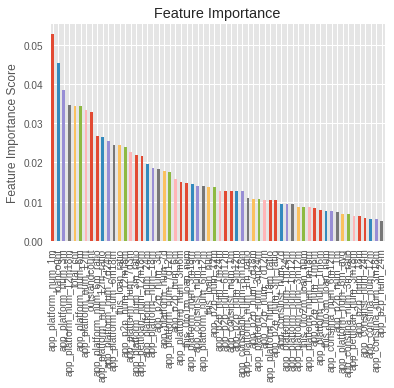

In [39]:
modelfit(xgb,X_ins, y_ins,selected_2, cv_folds=5)

##### 4.2.2 Model Stacking 

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#from mlxtend.classifier import StackingClassifier
import xgboost as xgb
from sklearn.cross_validation import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# submission = pd.read_csv(SUBMISSION_FILE)
# submission.iloc[:, 1] = np.exp(gbdt.predict(dtest))
# submission.to_csv('xgstacker_starter_v2.sub.csv', index=None)


In [59]:
# Stacking 模型融合采用缺失值填充后的数据
# 缺失值包括applist的数据,中金协和借记卡的数据，以-999999来填充
raw_data_st = raw_data.copy()
raw_data_st.fillna(-999999,inplace=True)
raw_data_ins_st = raw_data_st[raw_data_st['Group'] == 'INS']
raw_data_oos_st = raw_data_st[raw_data_st['Group'] == 'OOS']
X_ins_st = pd.DataFrame(raw_data_ins_st[final_cols],dtype=np.float)
X_oos_st = pd.DataFrame(raw_data_oos_st[final_cols],dtype=np.float)
y_ins_st = raw_data_ins_st['is_multiloan_1'].ravel()


NFOLDS = 4
SEED = 0
NROWS = None
print("{},{}".format(X_ins_st.shape, X_oos_st.shape))

ntrain = X_ins_st.shape[0]
ntest = X_oos_st.shape[0]
train_test = pd.concat((X_ins_st, X_oos_st)).reset_index(drop=True)

features = X_ins_st.columns

x_train = np.array(train_test.iloc[:ntrain,:])
x_test = np.array(train_test.iloc[ntrain:,:])

(171975, 318),(73285, 318)


In [15]:
missing_df = missing_values_table(raw_data_st)

Your selected dataframe has 345columns.
There are0columns that have missing values


In [63]:
kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print(i, train_index, test_index)
        x_tr = x_train[train_index]
        y_tr = y_ins_st[train_index]
        x_te = x_train[test_index]
        
        
        clf.train(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


In [64]:
et_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    
    
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features': 0.2,
    'max_depth': 8,
    'min_samples_leaf': 2,
}

gb_params = {
    'n_estimators': 100,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}


gb = SklearnWrapper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
et = SklearnWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)

gb_oof_train, gb_oof_test = get_oof(gb)
et_oof_train, et_oof_test = get_oof(et)
rf_oof_train, rf_oof_test = get_oof(rf)

print("GB-CV: {}".format(mean_absolute_error(y_ins_st, gb_oof_train)))
print("ET-CV: {}".format(mean_absolute_error(y_ins_st, et_oof_train)))
print("RF-CV: {}".format(mean_absolute_error(y_ins_st, rf_oof_train)))

0 [     1      2      3 ... 171734 171735 171736] [     0     12     17 ... 171722 171729 171732]
1 [     0      1      2 ... 171732 171733 171734] [     3      6      7 ... 171731 171735 171736]
2 [     0      2      3 ... 171732 171735 171736] [     1      4      5 ... 171725 171733 171734]
3 [     0      1      3 ... 171734 171735 171736] [     2     10     21 ... 171717 171719 171727]
0 [     1      2      3 ... 171734 171735 171736] [     0     12     17 ... 171722 171729 171732]
1 [     0      1      2 ... 171732 171733 171734] [     3      6      7 ... 171731 171735 171736]
2 [     0      2      3 ... 171732 171735 171736] [     1      4      5 ... 171725 171733 171734]
3 [     0      1      3 ... 171734 171735 171736] [     2     10     21 ... 171717 171719 171727]
0 [     1      2      3 ... 171734 171735 171736] [     0     12     17 ... 171722 171729 171732]
1 [     0      1      2 ... 171732 171733 171734] [     3      6      7 ... 171731 171735 171736]
2 [     0      2    

In [20]:
x_train = np.concatenate((gb_oof_train, et_oof_train, rf_oof_train), axis=1)
x_test = np.concatenate((gb_oof_test, et_oof_test, rf_oof_test), axis=1)

print("{},{}".format(x_train.shape, x_test.shape))

(171511, 3),(73749, 3)


In [33]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': 0.6,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
}

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

res = xgb.cv(xgb_params, dtrain, num_boost_round=500, nfold=4, seed=SEED, stratified=False,
             early_stopping_rounds=25, verbose_eval=10, show_stdv=True, feval=xg_eval_mae, maximize=False)

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]

print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std))

xgb_st = xgb.train(xgb_params, dtrain, best_nrounds)

KeyboardInterrupt: 

In [23]:
X=pd.DataFrame(x_train).values
y=pd.DataFrame(y_ins_st).values.reshape(pd.DataFrame(y_ins_st).values.shape[0],).astype('float64').astype(np.int64)

def XGB_CV(X,y):
    param_test = {
        'max_depth': list(range(5,10,2)),
        'n_estimators': list(range(50,100,10)),
    }
    estimator = XGBClassifier(
        learning_rate =0.1,
        n_estimators=80,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        reg_alpha=2,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
    gsearch = GridSearchCV( estimator , param_grid = param_test, scoring='roc_auc', cv=3)
    gsearch.fit(X, y)
    gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_
    
    # 输出best score
    print("Best score: %0.3f" % gsearch.best_score_)
    print("Best parameters set:")
    # 输出最佳的分类器到底使用了怎样的参数
    best_parameters = gsearch.best_estimator_.get_params()
    for param_name in sorted(param_test.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

XGB_CV(X,y)

Best score: 0.506
Best parameters set:
	max_depth: 5
	n_estimators: 50


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [24]:
X_ins_st = pd.DataFrame(x_train)
xgb_st = XGBClassifier(
            learning_rate =0.05,
            n_estimators=60,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            reg_alpha=10,
            reg_lamda=1,
            colsample_bytree=0.8,
            objective= 'binary:logistic',
            nthread=1,
            scale_pos_weight=1,
            seed=27)
w = np.where(raw_data_ins_st['s3d15']==1, 3, 1)
xgb_st = xgb_st.fit(x_train,y_ins_st,sample_weight=w)

##### Stacking II
尝试按照列聚类进行模型

### 5. Model Evalution

#### 5.1 Function 

In [40]:
# 评估指标为KS，PSI
def psi(expected_array, actual_array, buckets=10, buckettype='bins'):
    '''Calculate the PSI for a single variable 
    
    Args:
       expected_array: numpy array of original values
       actual_array: numpy array of new values, same size as expected
       buckets: number of percentile ranges to bucket the values into
       
    Returns:
       psi_value: calculated PSI value
    '''
        
    def scale_range (input, min, max):
        input += -(np.min(input))
        if max - min != 0:
            input /= np.max(input) / (max - min)
        input += min
        return input
    
    
    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
    
    if buckettype == 'bins':
        breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
    elif buckettype == 'quantiles':
        breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])
    
    def generate_counts(arr, breakpoints):
        '''Generates counts for each bucket by using the bucket values 
        
        Args:
           arr: ndarray of actual values
           breakpoints: list of bucket values
        
        Returns:
           counts: counts for elements in each bucket, length of breakpoints array minus one
        '''
    
        def count_in_range(arr, low, high, start):
            '''Counts elements in array between low and high values.
               Includes value if start is true
            '''
            if start:
                return(len(np.where(np.logical_and(arr>=low, arr<=high))[0]))
            return(len(np.where(np.logical_and(arr>low, arr<=high))[0]))
    
        
        counts = np.zeros(len(breakpoints)-1)
    
        for i in range(1, len(breakpoints)):
            counts[i-1] = count_in_range(arr, breakpoints[i-1], breakpoints[i], i==1)
    
        return(counts)
    
    
    expected_percents = generate_counts(expected_array, breakpoints) / len(expected_array)
    actual_percents = generate_counts(actual_array, breakpoints) / len(actual_array)
    
    def sub_psi(e_perc, a_perc):
        '''Calculate the actual PSI value from comparing the values.
           Update the actual value to a very small number if equal to zero
        '''
        if a_perc == 0:
            a_perc = 0.001
        if e_perc == 0:
            e_perc = 0.001
        
        value = (e_perc - a_perc) * np.log(e_perc / a_perc)
        return(value)
    
    psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

    return(psi_value)

def PSI_Calculate(InputDf,GroupVar,BenchmarkGroup,CompareGroup,Cols):
    expected=InputDf.loc[InputDf[GroupVar].isin(BenchmarkGroup),:][Cols].values
    Output=pd.DataFrame()
    for i in set(CompareGroup):
        actual=InputDf[InputDf[GroupVar]==i][Cols].values
        if len(expected.shape) == 1:
            psi_values = np.empty(len(expected.shape))
        else:
            psi_values = np.empty(expected.shape[1])
        for j in range(0, len(psi_values)):
            if len(psi_values) == 1:
                psi_values = psi(expected, actual, 10)
            else:
                psi_values[j] = psi(expected[:,j], actual[:,j], 10)
        ColsName=str(i)+'_PSI'
        psi_output=pd.DataFrame(psi_values,columns=[ColsName],index=Cols)
        Output=pd.concat([Output,psi_output],axis=1)
    return Output



def KS_Calculate(InputDf,GroupVar,GroupValue,Cols,TargetVar):
    '''
    功能: 利用scipy库函数计算每组中各变量的KS指标
    Args:
       InputDf: 输入的dataframe
       GroupVar: 分组依据，如按组（ins/oos/oot），月，周。示例: ['apply_month']
       GroupValue: 分组元素取值。示例: [201701, 201702]
       Cols: 特征列表。示例: ['x1', 'x2']
       TargetVar: 目标变量。示例: 's1d30'
    Returns:
       Output: 每组每个变量的ks报表，并按ks_mean降序排列显示
    '''
    InputDf=InputDf.loc[(InputDf[TargetVar].isin([0,1])),:]
    Output=pd.DataFrame()
    for Cols_i in set(Cols):
        OutputPre=pd.DataFrame()
        for Group_i in set(GroupValue):
            ks_value=ks_2samp(InputDf.loc[(InputDf[TargetVar]==1)&(InputDf[GroupVar]==Group_i)][Cols_i], InputDf.loc[(InputDf[TargetVar]==0)&(InputDf[GroupVar]==Group_i)][Cols_i]).statistic
            ColsName=str(Group_i)+'_KS'
            ks_output=pd.DataFrame(ks_value,columns=[ColsName],index=[Cols_i])
            OutputPre=pd.concat([OutputPre,ks_output],axis=1)
        Output=pd.concat([Output,OutputPre],axis=0)
    return Output

from function import *
def ks_auc(real,pred,bins=20):
    bad=pd.DataFrame(real,columns=['bad'])
    score=pd.DataFrame(pred,columns=['score'])
    data=pd.concat([bad,score],axis=1)
    data['good'] = 1 - data.bad
    data['bucket'] = pd.qcut(data.score,bins,duplicates='drop')
    grouped = data.groupby('bucket', as_index = False)
    table = pd.DataFrame(grouped.min().score, columns = ['min_score'])
    table['max_score'] = grouped.max().score
    table['min_score'] = grouped.min().score
    table['bads'] = grouped.sum().bad
    table['goods'] = grouped.sum().good
    table = (table.sort_values(by = 'min_score',ascending=False)).reset_index(drop = True)
    table['ks'] = np.round(((table.bads / data.bad.sum()).cumsum() - (table.goods / data.good.sum()).cumsum()), 4) * 100
    ks_max = table.ks.max()
    auc = metrics.roc_auc_score(real,pred)
    return (ks_max,auc)

def KS_PerformanceCheck(alg,InputData,Predicators,Target,Group,bins=20):
    
    Temp=InputData.loc[(InputData[Target[0]].isin([0,1])),:]
    Prob=pd.DataFrame(alg.predict_proba(Temp[Predicators])[:, 1],columns=['ProbScore'],index=Temp[Predicators].index)
    TempScore=pd.concat([Temp[['order_id','apply_time']+Target+Group],Prob],axis=1)
    
    group_ks_df=pd.DataFrame()
    for target in Target:
        ks_list = []
        auc_list = []
        group_list =[]
        for i in Group:
            for group in sorted(list(set(TempScore[i]))):
                if TempScore.loc[TempScore[i]==group,:][target].sum()>0:
                    data_set = TempScore.loc[(TempScore[i]==group) & (~TempScore[target].isnull()),:]
                    (ks,auc) = ks_auc(list(data_set[[target]].values),list(data_set[['ProbScore']].values),bins)
                    ks_list.append(ks)
                    auc_list.append(auc)
                    group_list.append(group)
        ks_df=pd.DataFrame(ks_list,columns=['KS_'+target],index=group_list)
        auc_df=pd.DataFrame(auc_list,columns=['AUC_'+target],index=group_list)
        group_ks_df=pd.concat([group_ks_df,ks_df,],axis=1)
        group_ks_df=pd.concat([group_ks_df,auc_df,],axis=1)        
    return group_ks_df


/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### 5.2 Evalution on td_after

##### 5.2.1 KS & AUC 

In [44]:
raw_data_after = raw_data_full.loc[raw_data_full['is_multiloan_3'].isin([0,1]),:]

In [45]:
raw_data_loaned_after = raw_data_loaned.loc[raw_data_loaned['is_multiloan_3'].isin([0,1]),:]

In [46]:
raw_data_after.shape

(516301, 354)

In [47]:
raw_data_loaned_after.shape

(512020, 356)

In [98]:
KS_PerformanceCheck(xgb,raw_data_loaned_after,selected_2,['is_multiloan_1','s1d30','s3d15'],['apply_month'],20)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:161: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:162: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:161: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/conda/lib/python3

,KS_is_multiloan_1,AUC_is_multiloan_1,KS_s1d30,AUC_s1d30,KS_s3d15,AUC_s3d15
2018-02,44.20,0.781813,26.61,0.668541,27.64,0.679406
2018-03,45.20,0.791505,23.99,0.661994,25.53,0.667852
2018-04,45.49,0.795438,29.37,0.687698,24.47,0.664570
2018-05,43.66,0.790943,27.23,0.672947,23.24,0.656320
2018-06,41.55,0.776898,20.53,0.637769,22.04,0.642897
2018-07,38.04,0.754704,23.65,0.661659,21.47,0.646942
2018-08,37.30,0.747324,23.35,0.620070,20.02,0.629612
2018-09,33.78,0.723513,NaN,NaN,NaN,NaN


##### 5.2.2 KS Table

In [41]:
def ks_table_adj(InputDf,Benchmark,ScoreVar,TargetVar,bins=20):
    '''
    功能：生成ks_table, 可观察每个bin内的正负样本数，几率，lift和ks
    Args:
       InputDf: 输入的dataframe
       ScoreVar: ks曲线横坐标变量。
       TargetVar: 目标变量，取值为1或0。示例: 's1d30'
       bins: 分箱数，默认20
       Ascending: ks曲线横坐标变量升序或降序，默认降序，不影响max_ks取值，仅影响顺序
    Returns:
       Output: ks_table, 结果见示例
    '''
    InputDf=InputDf.loc[(InputDf[TargetVar].isin([0,1])),:]
    data=InputDf[[ScoreVar,TargetVar]].copy()
    data.loc[:,'bad']=data[TargetVar]
    data.loc[:,'score']=data[ScoreVar]
    data.loc[:,'good']=1-data[TargetVar]
    
    break_points = np.stack([np.percentile(Benchmark, b) for b in np.arange(0, bins + 1) / (bins) * 100])
    #print(break_points)
    break_points = np.unique(break_points)
    labels=range(len(break_points)-1)
    data['bucket']=pd.cut(data.score,bins=break_points,labels=labels,include_lowest=True)
    grouped = data.groupby('bucket', as_index = False)
    table = pd.DataFrame(grouped.min().score, columns = ['min_score'])
    table['max_score'] = grouped.max().score
    table['min_score'] = grouped.min().score
    table['bads'] = grouped.sum().bad
    table['goods'] = grouped.sum().good
    table['total'] = table.bads + table.goods
    table['bucket_ratio'] = (table.total / table.total.sum()).apply('{0:.2%}'.format)
    table = (table.sort_values(by = 'min_score',ascending=False)).reset_index(drop = True)
    table['odds'] = (table.bads / table.goods).apply('{0:.2f}'.format)
    table['bad_rate'] = (table.bads / table.total).apply('{0:.2%}'.format)
    table['lift'] = ((table.bads / table.total) / (table.bads.sum()/table.total.sum())).apply('{0:.2f}'.format)
    table['cum_lift'] = ((table.bads.cumsum() / table.total.cumsum()) / (table.bads.sum()/table.total.sum())).apply('{0:.2f}'.format)
    table['cum_bad'] = ((table.bads / data.bad.sum()).cumsum()).apply('{0:.2%}'.format)
    table['cum_good'] = ((table.goods / data.good.sum()).cumsum()).apply('{0:.2%}'.format)
    table['ks'] = np.round(((table.bads / data.bad.sum()).cumsum() - (table.goods / data.good.sum()).cumsum()), 4) * 100
    flag = lambda x: '<<<<<<' if x == table.ks.max() else ''
    table['max_ks'] = table.ks.apply(flag)
    Output=table[['total','min_score','max_score','bucket_ratio','bads','bad_rate','cum_bad','cum_good','odds','lift','cum_lift','ks','max_ks']]
    #print (break_points)
    return Output

def KS_Table_Adj_Calculate(InputDf,GroupVar,GroupValue,Benchmark,ScoreVar,TargetVar,bins=20,SingleOutput=False):
    InputDf=InputDf.loc[(InputDf[TargetVar].isin([0,1])),:]
    Output=ks_table_adj(InputDf.loc[InputDf[GroupVar].isin(GroupValue),:],Benchmark,ScoreVar,TargetVar,bins)
    GroupValueTemp=[ str(i) for i in GroupValue ]
    Output.loc[:,GroupVar]="+".join(GroupValueTemp)
    OutputPre=pd.DataFrame()
    if SingleOutput==True:
        for Group_i in set(GroupValue):
            KS_Table=ks_table_adj(InputDf[InputDf[GroupVar]==Group_i],Benchmark,ScoreVar,TargetVar,bins)
            KS_Table.loc[:,GroupVar]=Group_i
            OutputPre=pd.concat([OutputPre,KS_Table],axis=0)       
    Output=pd.concat([Output,OutputPre],axis=0)
    return Output


In [89]:
alg = xgb

InputData=raw_data_after
Predicators=selected_1

KeepCols=['order_id', 'apply_date','apply_month','Group','is_multiloan_3','s1d30','s3d15','s1d4_30']

ColumnName='Score'
Prob=pd.DataFrame(alg.predict_proba(InputData[Predicators])[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf=pd.concat([InputData[KeepCols],Prob],axis=1)


GroupVar='apply_month'
GroupValue=['2017-12','2018-01','2018-02','2018-03','2018-04','2018-05','2018-06']
Benchmark=ScoreDf[ScoreDf['apply_month']=='2018-02']['Score']
ScoreVar='Score'
TargetVar='s1d30'
OutputCols=['apply_month','total','min_score','max_score','bucket_ratio','bads','bad_rate','cum_bad','cum_good','odds','lift','cum_lift','ks','max_ks']
KS_Table=KS_Table_Adj_Calculate(ScoreDf,GroupVar,GroupValue,Benchmark,ScoreVar,TargetVar,20,True)[OutputCols]

ValueError: feature_names mismatch: ['app_p2p_num_6m_ratio', 'app_p2p_num_6m12m', 'app_pettloan_num_3m18m', 'app_platform_num_12m18m', 'app_p2p_num_1m24m', 'app_consinst_num_12m18m', 'app_platform_num_18m', 'app_p2p_num_7d12m', 'app_consinst_num_18m24m', 'app_p2p_num_7d6m', 'app_pettloan_num_6m24m', 'app_consinst_num_12m24m', 'app_consinst_num_1m6m', 'app_platform_num_3m24m', 'app_platform_num_6m', 'app_p2p_num_24m', 'app_platform_num_7d', 'app_platform_num_18m24m', 'app_consbank_num_6m18m', 'app_consinst_num_1m_avg', 'app_platform_num_6m18m', 'app_platform_num_7d12m', 'app_pettloan_num_3m24m', 'app_p2p_num_12m18m', 'app_platform_num_1m_ratio', 'app_platform_num_1m12m', 'app_platform_num_12m24m', 'app_pettloan_num_1m3m', 'app_platform_num_6m12m', 'app_consbank_num_3m12m', 'app_consinst_num_1m3m', 'app_consinst_num_7d24m', 'app_consinst_num_6m', 'app_consinst_num_1m_ratio', 'app_pettloan_num_3m12m', 'app_platform_num_3m', 'app_consfina_num_12m', 'app_pettloan_num_1m', 'app_consinst_num_6m18m', 'app_platform_num_1m24m', 'app_p2p_num_7d18m', 'app_p2p_num_3m6m', 'app_pettloan_num_3m', 'app_consinst_num_1m', 'app_consinst_num_1m12m', 'app_consbank_num_1m', 'app_pettloan_num_3m6m', 'app_consbank_num_1m_ratio', 'app_p2p_num_3m', 'app_platform_num_7d24m', 'app_p2p_num_1m12m', 'app_p2p_num_6m24m', 'app_consinst_num_3m', 'app_consinst_num_7d18m', 'app_p2p_num_12m', 'app_consinst_num_3m18m', 'app_consinst_num_1m24m', 'app_p2p_num_1m6m', 'app_consinst_num_18m', 'app_consinst_num_7d12m', 'app_p2p_num_18m24m', 'app_p2p_num_1m_ratio', 'app_consinst_num_7d3m', 'app_consinst_num_12m', 'app_pettloan_num_12m24m', 'app_p2p_num_3m18m', 'app_platform_num_3m_ratio', 'app_pettloan_num_1m24m', 'app_p2p_num_12m24m', 'app_consbank_num_18m', 'app_pettloan_num_6m', 'loanbal', 'app_p2p_num_7d3m', 'app_platform_num_1m18m', 'app_consinst_num_7d', 'app_platform_num_3m6m', 'app_platform_num_7d6m', 'app_consinst_num_24m', 'app_consinst_num_7d1m', 'app_consbank_num_3m', 'app_consbank_num_1m18m', 'app_platform_num_7d18m', 'app_pettloan_num_1m12m', 'app_pettloan_num_12m', 'app_pettloan_num_18m', 'app_consbank_num_12m24m', 'app_platform_num_3m12m', 'app_consinst_num_6m24m', 'app_p2p_num_7d24m', 'app_consbank_num_6m12m', 'app_platform_num_24m', 'app_platform_num_7d1m', 'app_consinst_num_3m24m', 'app_consbank_num_6m24m', 'app_p2p_num_3m_avg', 'app_consfina_num_18m24m', 'app_platform_num_6m_avg', 'app_pettloan_num_1m6m', 'app_consbank_num_6m', 'app_p2p_num_7d', 'app_p2p_num_18m', 'app_consinst_num_3m12m', 'app_pettloan_num_1m_ratio', 'app_pettloan_num_3m_avg', 'app_consinst_num_7d6m', 'app_platform_num_1m3m', 'app_platform_num_1m6m', 'app_consbank_num_1m3m', 'app_consbank_num_3m24m', 'app_platform_num_7d3m', 'app_consbank_num_3m6m', 'app_p2p_num_3m24m', 'app_platform_num_3m_avg', 'app_consbank_num_12m18m', 'app_platform_num_3m18m', 'app_p2p_num_1m', 'app_platform_num_12m', 'app_consinst_num_3m6m', 'app_consbank_num_1m12m', 'app_pettloan_num_24m', 'app_consinst_num_6m12m', 'app_p2p_num_7d1m', 'app_pettloan_num_6m12m', 'app_consbank_num_1m24m', 'app_p2p_num_6m18m', 'app_p2p_num_6m', 'app_platform_num_1m', 'app_consbank_num_3m18m', 'app_pettloan_num_18m24m', 'app_platform_num_6m24m', 'app_consbank_num_12m', 'loanamt', 'app_platform_num_1m_avg', 'app_pettloan_num_12m18m', 'app_p2p_num_6m_avg', 'app_pettloan_num_1m18m', 'app_consbank_num_24m', 'app_pettloan_num_1m_avg', 'app_p2p_num_3m12m', 'app_p2p_num_1m18m', 'app_consbank_num_1m6m', 'app_p2p_num_1m3m', 'app_p2p_num_1m_avg', 'app_consbank_num_18m24m', 'app_consinst_num_1m18m', 'app_p2p_num_3m_ratio', 'bank_num', 'app_pettloan_num_6m18m'] ['app_p2p_num_6m_ratio', 'app_p2p_num_6m12m', 'app_pettloan_num_3m18m', 'app_platform_num_12m18m', 'app_p2p_num_1m24m', 'app_consinst_num_12m18m', 'app_platform_num_18m', 'app_p2p_num_7d12m', 'app_consinst_num_18m24m', 'app_p2p_num_7d6m', 'app_pettloan_num_6m24m', 'app_consinst_num_12m24m', 'app_consinst_num_1m6m', 'app_platform_num_3m24m', 'app_platform_num_6m', 'app_p2p_num_24m', 'app_platform_num_7d', 'app_platform_num_18m24m', 'app_consbank_num_6m18m', 'app_consinst_num_1m_avg', 'app_platform_num_6m18m', 'app_platform_num_7d12m', 'app_pettloan_num_3m24m', 'outstandcount', 'app_p2p_num_12m18m', 'app_platform_num_1m_ratio', 'app_platform_num_1m12m', 'app_platform_num_12m24m', 'app_pettloan_num_1m3m', 'app_platform_num_6m12m', 'app_consbank_num_3m12m', 'app_consinst_num_1m3m', 'app_consinst_num_7d24m', 'app_consinst_num_6m', 'app_consinst_num_1m_ratio', 'app_pettloan_num_3m12m', 'app_platform_num_3m', 'app_consfina_num_12m', 'app_pettloan_num_1m', 'app_consinst_num_6m18m', 'app_platform_num_1m24m', 'app_p2p_num_7d18m', 'app_p2p_num_3m6m', 'app_pettloan_num_3m', 'app_consinst_num_1m', 'app_consinst_num_1m12m', 'app_consbank_num_1m', 'app_pettloan_num_3m6m', 'app_consbank_num_1m_ratio', 'app_p2p_num_3m', 'app_platform_num_7d24m', 'app_p2p_num_1m12m', 'app_p2p_num_6m24m', 'app_consinst_num_3m', 'app_consinst_num_7d18m', 'app_p2p_num_12m', 'app_consinst_num_3m18m', 'app_consinst_num_1m24m', 'app_p2p_num_1m6m', 'app_consinst_num_18m', 'app_consinst_num_7d12m', 'app_p2p_num_18m24m', 'app_p2p_num_1m_ratio', 'app_consinst_num_7d3m', 'app_consinst_num_12m', 'app_pettloan_num_12m24m', 'app_p2p_num_3m18m', 'app_platform_num_3m_ratio', 'app_pettloan_num_1m24m', 'app_p2p_num_12m24m', 'app_consbank_num_18m', 'apply_before_cnt', 'app_pettloan_num_6m', 'loanbal', 'app_p2p_num_7d3m', 'app_platform_num_1m18m', 'app_consinst_num_7d', 'app_platform_num_3m6m', 'app_platform_num_7d6m', 'app_consinst_num_24m', 'app_consinst_num_7d1m', 'app_consbank_num_3m', 'app_consbank_num_1m18m', 'app_platform_num_7d18m', 'app_pettloan_num_1m12m', 'loancount', 'app_pettloan_num_12m', 'app_pettloan_num_18m', 'app_consbank_num_12m24m', 'app_platform_num_3m12m', 'app_consinst_num_6m24m', 'app_p2p_num_7d24m', 'app_consbank_num_6m12m', 'app_platform_num_24m', 'app_platform_num_7d1m', 'app_consinst_num_3m24m', 'app_consbank_num_6m24m', 'app_p2p_num_3m_avg', 'app_consfina_num_18m24m', 'app_platform_num_6m_avg', 'app_pettloan_num_1m6m', 'app_consbank_num_6m', 'app_p2p_num_7d', 'app_p2p_num_18m', 'app_consinst_num_3m12m', 'app_pettloan_num_1m_ratio', 'app_pettloan_num_3m_avg', 'app_consinst_num_7d6m', 'app_platform_num_1m3m', 'app_platform_num_1m6m', 'app_consbank_num_1m3m', 'app_consbank_num_3m24m', 'app_platform_num_7d3m', 'app_consbank_num_3m6m', 'app_p2p_num_3m24m', 'app_platform_num_3m_avg', 'app_consbank_num_12m18m', 'app_platform_num_3m18m', 'app_p2p_num_1m', 'app_platform_num_12m', 'app_consinst_num_3m6m', 'app_consbank_num_1m12m', 'app_pettloan_num_24m', 'app_consinst_num_6m12m', 'app_p2p_num_7d1m', 'app_pettloan_num_6m12m', 'app_consbank_num_1m24m', 'app_p2p_num_6m18m', 'app_p2p_num_6m', 'app_platform_num_1m', 'app_consbank_num_3m18m', 'app_pettloan_num_18m24m', 'app_platform_num_6m24m', 'app_consbank_num_12m', 'loanamt', 'app_platform_num_1m_avg', 'app_pettloan_num_12m18m', 'app_p2p_num_6m_avg', 'app_pettloan_num_1m18m', 'app_consbank_num_24m', 'app_pettloan_num_1m_avg', 'app_p2p_num_3m12m', 'app_p2p_num_1m18m', 'app_consbank_num_1m6m', 'app_p2p_num_1m3m', 'app_p2p_num_1m_avg', 'app_consbank_num_18m24m', 'app_consinst_num_1m18m', 'app_p2p_num_3m_ratio', 'bank_num', 'app_pettloan_num_6m18m']
training data did not have the following fields: apply_before_cnt, outstandcount, loancount

#### 5.2 Evalution on all sample

##### 5.3.1 KS & AUC 

In [43]:
# raw_data_loaned 全量放款订单，raw_data_full 全部订单
KS_PerformanceCheck(xgb,raw_data_loaned,selected_2,['s1d30','s1d4_30','s3d15'],['apply_month'],20)

,KS_s1d30,AUC_s1d30,KS_s1d4_30,AUC_s1d4_30,KS_s3d15,AUC_s3d15
2018-02,23.74,0.659005,35.05,0.712587,26.87,0.678731
2018-03,23.18,0.652003,24.19,0.647726,25.90,0.669961
2018-04,29.78,0.688144,25.94,0.659048,25.76,0.669506
2018-05,28.13,0.674146,21.49,0.644322,24.94,0.667705
2018-06,22.82,0.647505,18.39,0.613156,24.02,0.658717
2018-07,26.87,0.669223,19.70,0.621510,25.28,0.666632
2018-08,23.02,0.612477,30.02,0.613797,21.77,0.637498


##### 5.3.2 KS Table 

In [55]:
def ks_table_full(InputDf,ScoreVar,TargetVar,LoanVar,EffVar,
                  Mode='sample_avg',bins=20,ascending=False,Benchmark=None,Points_list=None):     
    data=InputDf.copy()
    data.loc[:,'rej']=1-data[LoanVar]
    data.loc[:,'loan']=data[LoanVar]
    data.loc[:,'bad']=data[TargetVar]*data[EffVar]
    data.loc[:,'good']=(data[LoanVar]-data[TargetVar])*data[EffVar]
    data.loc[:,'score']=data[ScoreVar]
    
    if Mode == 'sample_avg':
        data['bucket'] = pd.qcut(data.score,bins,duplicates='drop')
    elif Mode == 'sample_ins':
        break_points = np.stack([np.percentile(Benchmark, b) for b in np.arange(0, bins + 1) / (bins) * 100])
        labels=range(len(break_points)-1)
        data['bucket']=pd.cut(data.score,bins=break_points,labels=labels,include_lowest=True)
    elif Mode == 'score_avg':
        break_points = Points_list
        labels=range(len(break_points)-1)
        data['bucket']=pd.cut(data.score,bins=break_points,labels=labels,include_lowest=True)
    else:
        print ('Mode模式错误')
        return
    
    grouped = data.groupby('bucket', as_index = False)

    table = pd.DataFrame(grouped.min().score, columns = ['min_score'])
    table['max_score'] = grouped.max().score
    table['min_score'] = grouped.min().score
    table['bads'] = grouped.sum().bad
    table['goods'] = grouped.sum().good
    table['rejs'] = grouped.sum().rej
    table['loans'] = grouped.sum().loan
    table['total'] = table.rejs + table.loans
    table['effects']=table.goods + table.bads
    table['rej_ratio'] = (table.rejs / table.total).apply('{0:.2%}'.format)
    table['loan_ratio'] = (table.loans / table.total).apply('{0:.2%}'.format)
    
    table['bucket_ratio'] = (table.total / table.total.sum()).apply('{0:.2%}'.format)
    table = (table.sort_values(by = 'min_score',ascending=ascending)).reset_index(drop = True)
    table['odds'] = (table.bads / table.goods).apply('{0:.2f}'.format)
    table['bad_rate'] = (table.bads / table.effects).apply('{0:.2%}'.format)
    table['lift'] = ((table.bads / table.effects) / (table.bads.sum()/table.effects.sum())).apply('{0:.2f}'.format)
    table['cum_bad'] = ((table.bads / data.bad.sum()).cumsum()).apply('{0:.2%}'.format)
    table['cum_good'] = ((table.goods / data.good.sum()).cumsum()).apply('{0:.2%}'.format)
   
    table['cum_loan'] = ((table.loans / data.loan.sum()).cumsum()).apply('{0:.2%}'.format)
    table['cum_lift'] = ((table.bads.cumsum() / table.effects.cumsum()) / (table.bads.sum()/table.effects.sum())).apply('{0:.2f}'.format)
    
    table['ks'] = np.round(((table.bads / data.bad.sum()).cumsum() - (table.goods / data.good.sum()).cumsum()), 4) * 100
    flag = lambda x: '<<<<<<' if x == table.ks.max() else ''
    table['max_ks'] = table.ks.apply(flag)
    Output=table[['total','min_score','max_score','bucket_ratio','rejs','rej_ratio','loans','loan_ratio','cum_loan','effects','bads','bad_rate','cum_bad','odds','lift','cum_lift','ks','max_ks']]
    #print (Output)
    return Output

def ks_table_full_store(InputData,ScoreVar,TargetVar,LoanVar,EffVar,GroupVar,file_name,Mode='sample_avg',
                        bins=10,ascending=False,BenchmarkVal=None,BenchmarkLoan=None,Points_list=None):
    
    Benchmark = InputData[(InputData[GroupVar].isin(BenchmarkVal)) 
                          & (InputData[LoanVar].isin(BenchmarkLoan))][ScoreVar]
    
    ks_table_result = pd.DataFrame()
    for group in sorted(list(set(InputData[GroupVar]))):
        data_set = InputData.loc[InputData[GroupVar]==group,:]
        if data_set[TargetVar].sum()>0:
            ks_table_name = ("%s_table" % group)
            #print ('KS Table for %s' % group)
            ks_table_name = ks_table_full(data_set,ScoreVar,TargetVar,LoanVar,EffVar,Mode,bins,ascending,Benchmark,Points_list)
            ks_table_name.loc[:,GroupVar] = group
            ks_table_result=pd.concat([ks_table_result,ks_table_name],axis=0)
    
    if file_name != '':
        ks_table_result.to_csv(file_name,sep=',',header=True)

def ks_table_full_union(InputData,ScoreVar,TargetVar,LoanVar,EffVar,GroupVar,file_name,Mode='sample_avg',
                        bins=10,ascending=False,BenchmarkVal=None,BenchmarkLoan=None,Points_list=None):
    
    Benchmark = InputData[(InputData[GroupVar].isin(BenchmarkVal)) 
                          & (InputData[LoanVar].isin(BenchmarkLoan))][ScoreVar]
    
    union_data_set = InputData.loc[InputData[GroupVar].isin(BenchmarkVal),:]
    ks_table_union = ks_table_full(union_data_set,ScoreVar,TargetVar,LoanVar,EffVar,Mode,bins,ascending,Benchmark,Points_list)
    ks_table_union.loc[:,GroupVar]="Benchmark"
    
    ks_table_result = pd.DataFrame()
    for group in sorted(list(set(InputData[GroupVar]))):
        data_set = InputData.loc[InputData[GroupVar]==group,:]
        if data_set[TargetVar].sum()>0:
            ks_table_name = ("%s_table" % group)
            #print ('KS Table for %s' % group)
            ks_table_name = ks_table_full(data_set,ScoreVar,TargetVar,LoanVar,EffVar,Mode,bins,ascending,Benchmark,Points_list)
            ks_table_name.loc[:,GroupVar] = group
            ks_table_result=pd.concat([ks_table_result,ks_table_name],axis=0)
    
    ks_table_result = pd.concat([ks_table_union,ks_table_result],axis=0)
    
    if file_name != '':
        ks_table_result.to_csv(file_name,sep=',',header=True)

全量订单上的效果

In [56]:
Prob=pd.DataFrame(xgb.predict_proba(raw_data_full[selected_1])[:, 1],columns=['score'],index=raw_data_full[selected_1].index)
raw_data_full_score=pd.concat([raw_data_full,Prob],axis=1)

In [57]:
# 贷后多头模式覆盖
raw_data_full_score['is_eff_multiloan'] = 1

In [61]:
InputData = raw_data_full_score
ScoreVar = 'score'
TargetVar = 'is_loan'
LoanVar = 'is_loan'
EffVar = 'is_eff_multiloan'
GroupVar = 'apply_month'
file_name = OutputPath+'/ks_table_ins_loan_order_1009.csv'
BenchmarkVal = ['2018-04','2018-05','2018-06']
BenchmarkLoan =[0,1]
#Benchmark=df[(df[GroupVar].isin([201803,201804])) & (df[LoanVar]==1)][ScoreVar]

ks_table_full_union(InputData,ScoreVar,TargetVar,LoanVar,EffVar,GroupVar,file_name,Mode='sample_ins',bins=20,
                    ascending=False,BenchmarkVal=BenchmarkVal,BenchmarkLoan=BenchmarkLoan)

全量放款订单上的效果

① 多头模式的保序性

② 申贷占比的PSI

③ 分档BadRate(S1D30)的保序性

In [62]:
Prob=pd.DataFrame(xgb.predict_proba(raw_data_loaned[selected_1])[:, 1],columns=['score'],index=raw_data_loaned[selected_1].index)
raw_data_score=pd.concat([raw_data_loaned,Prob],axis=1)

In [63]:
raw_data_score['is_eff'] = 1

In [64]:
raw_data_score['multiloan_3'] = raw_data_score['is_multiloan_3']

In [65]:
raw_data_score.loc[raw_data_score['is_multiloan_3'] ==-1,'multiloan_3']=np.nan

In [66]:
set(raw_data_score['Group'])

{'INS', 'NA', 'OOS', 'OOT1', 'OOT2'}

In [67]:
# 分Group来看多头稳定性
InputData = raw_data_score
ScoreVar = 'score'
TargetVar = 'multiloan_3'
LoanVar = 'is_loan'
EffVar = 'is_eff'
GroupVar = 'Group'
file_name = OutputPath+'/ks_table_ins_loan_order_bygroup_1009.csv'
BenchmarkVal = ['INS']
BenchmarkLoan =[1]
#Benchmark=df[(df[GroupVar].isin([201803,201804])) & (df[LoanVar]==1)][ScoreVar]

ks_table_full_union(InputData,ScoreVar,TargetVar,LoanVar,EffVar,GroupVar,file_name,Mode='sample_ins',bins=20,
                    ascending=False,BenchmarkVal=BenchmarkVal,BenchmarkLoan=BenchmarkLoan)

In [68]:
# 分月来看多头稳定性
InputData = raw_data_score
ScoreVar = 'score'
TargetVar = 'multiloan_3'
LoanVar = 'is_loan'
EffVar = 'is_eff'
GroupVar = 'apply_month'
file_name = OutputPath+'/ks_table_ins_loan_order_bymonth_1009.csv'
BenchmarkVal = ['2018-04','2018-05','2018-06']
BenchmarkLoan =[1]
#Benchmark=df[(df[GroupVar].isin([201803,201804])) & (df[LoanVar]==1)][ScoreVar]

ks_table_full_union(InputData,ScoreVar,TargetVar,LoanVar,EffVar,GroupVar,file_name,Mode='sample_ins',bins=20,
                    ascending=False,BenchmarkVal=BenchmarkVal,BenchmarkLoan=BenchmarkLoan)

In [54]:
# 分月来看S1D30稳定性
InputData = raw_data_score
ScoreVar = 'score'
TargetVar = 's1d30'
LoanVar = 'is_loan'
EffVar = 'is_eff'
GroupVar = 'apply_month'
file_name = OutputPath+'/ks_table_ins_fraud_order_bymonth_0928.csv'
BenchmarkVal = ['2018-03','2018-04','2018-05']
BenchmarkLoan =[1]
#Benchmark=df[(df[GroupVar].isin([201803,201804])) & (df[LoanVar]==1)][ScoreVar]

ks_table_full_union(InputData,ScoreVar,TargetVar,LoanVar,EffVar,GroupVar,file_name,Mode='sample_ins',bins=20,
                    ascending=False,BenchmarkVal=BenchmarkVal,BenchmarkLoan=BenchmarkLoan)

In [ ]:
# 评估
#① 新增拒绝样本
#② 点估计，在INS，OOS和OOT上的差距
#③ 根据模型评估周报标准化

In [ ]:
# 2018-09-19 优化方向
一、特征工程方面
① 针对选出的155个特征进行特征构造
② 对中金协变量进行消除量纲的处理
③ 利用均值CV，PSI，IV进行变量筛选
二、target方面
选择表现期21天的情况，以及重新定义高低
三、样本选取方面
3，4，5月份为INS，6，7月份为OOT
四、模型框架上
尝试分变量进行子模型构建，并stacking



# 效果不好
# 特征全都被Boruta给删除掉了
# 使用第一版的特征，加入applist的特征，中金协的特征等
# 按照Stacking的方式进行尝试

In [107]:
# 对比Multiloan_v1的效果
from pyhive import hive
import pandas as pd
conn = hive.Connection(host='172.16.28.58', port=10000, username='zhangxiaojing', password='xj@28zxj@19', database='vdm_ds_dev', auth='LDAP')
raw_data_v1 = pd.read_sql("select t.* from zxj_multiloan_version_1_score t where to_date(apply_time)>='2018-02-01' and to_date(apply_time)<='2018-10-01'", conn)
raw_data_v1.columns = raw_data_v1.columns.str[2:]
raw_data_v1['apply_date'] = raw_data_v1.apply_time.str[:10]
raw_data_v1['apply_month'] = raw_data_v1.apply_time.str[:7]


In [114]:
Target = ['is_multiloan_1','s1d30','s3d15','s1d4_30']
InputData = raw_data_v1
Temp=InputData.loc[(InputData[Target[0]].isin([0,1])),:]
Group = 'apply_month'
list = ['order_id','apply_time','score','is_multiloan_1','s1d30','s3d15','s1d4_30','apply_month']
TempScore=pd.DataFrame(Temp[list])

In [125]:
def KS_PerformanceCheck_v1(InputData,Target,Group,bins=20):
    
    Temp=InputData.loc[(InputData[Target[0]].isin([0,1])),:]
    #Prob=pd.DataFrame(alg.predict_proba(Temp[Predicators])[:, 1],columns=['ProbScore'],index=Temp[Predicators].index)
    templist = ['order_id','apply_time','score']+Target+Group
    TempScore= pd.DataFrame(Temp[templist])
    
    group_ks_df=pd.DataFrame()
    for target in Target:
        ks_list = []
        auc_list = []
        group_list =[]
        for i in Group:
            for group in sorted(set(TempScore[i])):
                if TempScore.loc[TempScore[i]==group,:][target].sum()>0:
                    data_set = TempScore.loc[(TempScore[i]==group) & (~TempScore[target].isnull()),:]
                    (ks,auc) = ks_auc(data_set[[target]].values,data_set[['score']].values,bins)
                    ks_list.append(ks)
                    auc_list.append(auc)
                    group_list.append(group)
        ks_df=pd.DataFrame(ks_list,columns=['KS_'+target],index=group_list)
        auc_df=pd.DataFrame(auc_list,columns=['AUC_'+target],index=group_list)
        group_ks_df=pd.concat([group_ks_df,ks_df,],axis=1)
        group_ks_df=pd.concat([group_ks_df,auc_df,],axis=1)        
    return group_ks_df     


In [128]:
KS_PerformanceCheck_v1(raw_data_v1,['s1d30','s1d4_30','s3d15','is_multiloan_1'],['apply_month'],20)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,KS_s1d30,AUC_s1d30,KS_s1d4_30,AUC_s1d4_30,KS_s3d15,AUC_s3d15,KS_is_multiloan_1,AUC_is_multiloan_1
2018-02,26.39,0.670272,36.65,0.713354,28.57,0.687698,45.53,0.792308
2018-03,23.39,0.654788,23.14,0.642103,26.08,0.670061,44.75,0.788293
2018-04,27.92,0.680791,24.32,0.654963,25.99,0.668469,43.31,0.780172
2018-05,25.42,0.669820,20.72,0.637694,24.57,0.662037,41.05,0.771937
2018-06,22.19,0.636620,16.72,0.607992,23.69,0.651825,38.71,0.756320
2018-07,26.32,0.665569,18.25,0.619824,25.59,0.663097,37.67,0.748144
2018-08,25.02,0.619937,30.02,0.577653,21.77,0.634938,36.08,0.738755
2018-09,NaN,NaN,NaN,NaN,NaN,NaN,32.33,0.715358
